导入第三方库

In [2]:
import utils
import re,os,shutil,random

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime

工具函数

In [3]:
# 获取当前时间年月日时分秒
def get_time():
    now = datetime.datetime.now()
    return now.strftime('%H%M%S')

将图像文件分类  
*在ipynb文件中，文件起始地址为当前文件夹*

In [15]:

file_list = utils.get_file_list('../My_image/original')
file_list1 = {}
mouse_numbers = [3,4,12,51]           # 小鼠编号
tape_stripping_numbers = [0,2,4,6,8]  # 胶带剥离次数
fangda = [20,50]                      # 放大倍数
polarization = [0,90]                 # 是否偏振
shiyan_numbers = [0,1,2]              # 实验组号

for file in file_list:
    filename = re.split('_\d_\d\.jpg', file)
    file_list1[filename[0]] = file_list1[filename[0]] + 1 if filename[0] in file_list1 else 0

for i in mouse_numbers:
    for j in polarization:
        for k in fangda:
            # 新建文件夹
            new_path = '../My_image/group_tape_stripping_numbers/' + str(i) + '_' + str(k) + '_' + str(j)
            if not os.path.exists(new_path):
                os.makedirs(new_path)
            for l in tape_stripping_numbers:
                # 随机抽取文件
                shutil.copy('../My_image/original/'+ str(i) + '_' + str(l) + '_' + str(k) + '_' + str(j)+'_3_'+str(random.choice(shiyan_numbers))+'.jpg', \
                    new_path + '/' + str(i) + '_' + str(l) + '_' + str(k) + '_' + str(j) +'.jpg')

转为灰度图像

In [ ]:
file_list = utils.get_file_list('../My_image/group_tape_stripping_numbers/3_20_0')
for file in file_list:
    print(file)
    img = cv2.imread('../My_image/group_tape_stripping_numbers/3_20_0/'+file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.hist(gray.ravel(),256,[0,256]) # ravel()函数将多维数组降为一维
    plt.show()

cv2.waitKey(0)

得到ROI的区域坐标

In [4]:
# img = cv2.imread("My_image/group_tape_stripping_numbers/3_20_0/3_0_20_0.jpg")
# roi = cv2.selectROI(windowName="roi", img=img, showCrosshair=True, fromCenter=False)
x, y, w, h = (119,130,263,133)
img = cv2.imread('../My_image/group_tape_stripping_numbers/3_20_0/3_0_20_0.jpg')
# 获取矩阵最大值

print(img.min())
# cv2.waitKey(0)
# cv2.destroyAllWindows()

42


提取ROI

In [ ]:
file_list = utils.get_file_list('../My_image/group_tape_stripping_numbers/4_20_0')
for file in file_list:
    img = cv2.imread('../My_image/group_tape_stripping_numbers/4_20_0/'+file)
    imgROI = img[y:y+h, x:x+w].copy()
    grayROI = cv2.cvtColor(imgROI, cv2.COLOR_BGR2GRAY)
    plt.hist(grayROI.ravel(),256,[0,256])
    plt.show()
cv2.waitKey(0)

求三通道直方图以及直方图均值  
**cv2读取是BGR，plt读取是RGB**

In [6]:
# 计算三个通道的直方图
def hist(image,ax):
    color = ('blue','green','red')
    for i,color in enumerate(color):
        hist = cv2.calcHist([image],[i],None,[256],[0,256])
        ax.plot(hist,color=color)
        ax.set_xlim([0,256])

def hist_mean(image):
    color = ('blue','green','red')
    mean = []
    for i,color in enumerate(color):
        hist = cv2.calcHist([image],[i],None,[256],[0,256])
        sum = 0
        for j,hist1 in enumerate(hist):
            sum = sum + (j+1)*hist1
        mean.append(round(sum[0]/image.shape[0]/image.shape[1],2))
    return mean

计算五张图片的提取ROI均值滤波直方图(合并在一张图上)

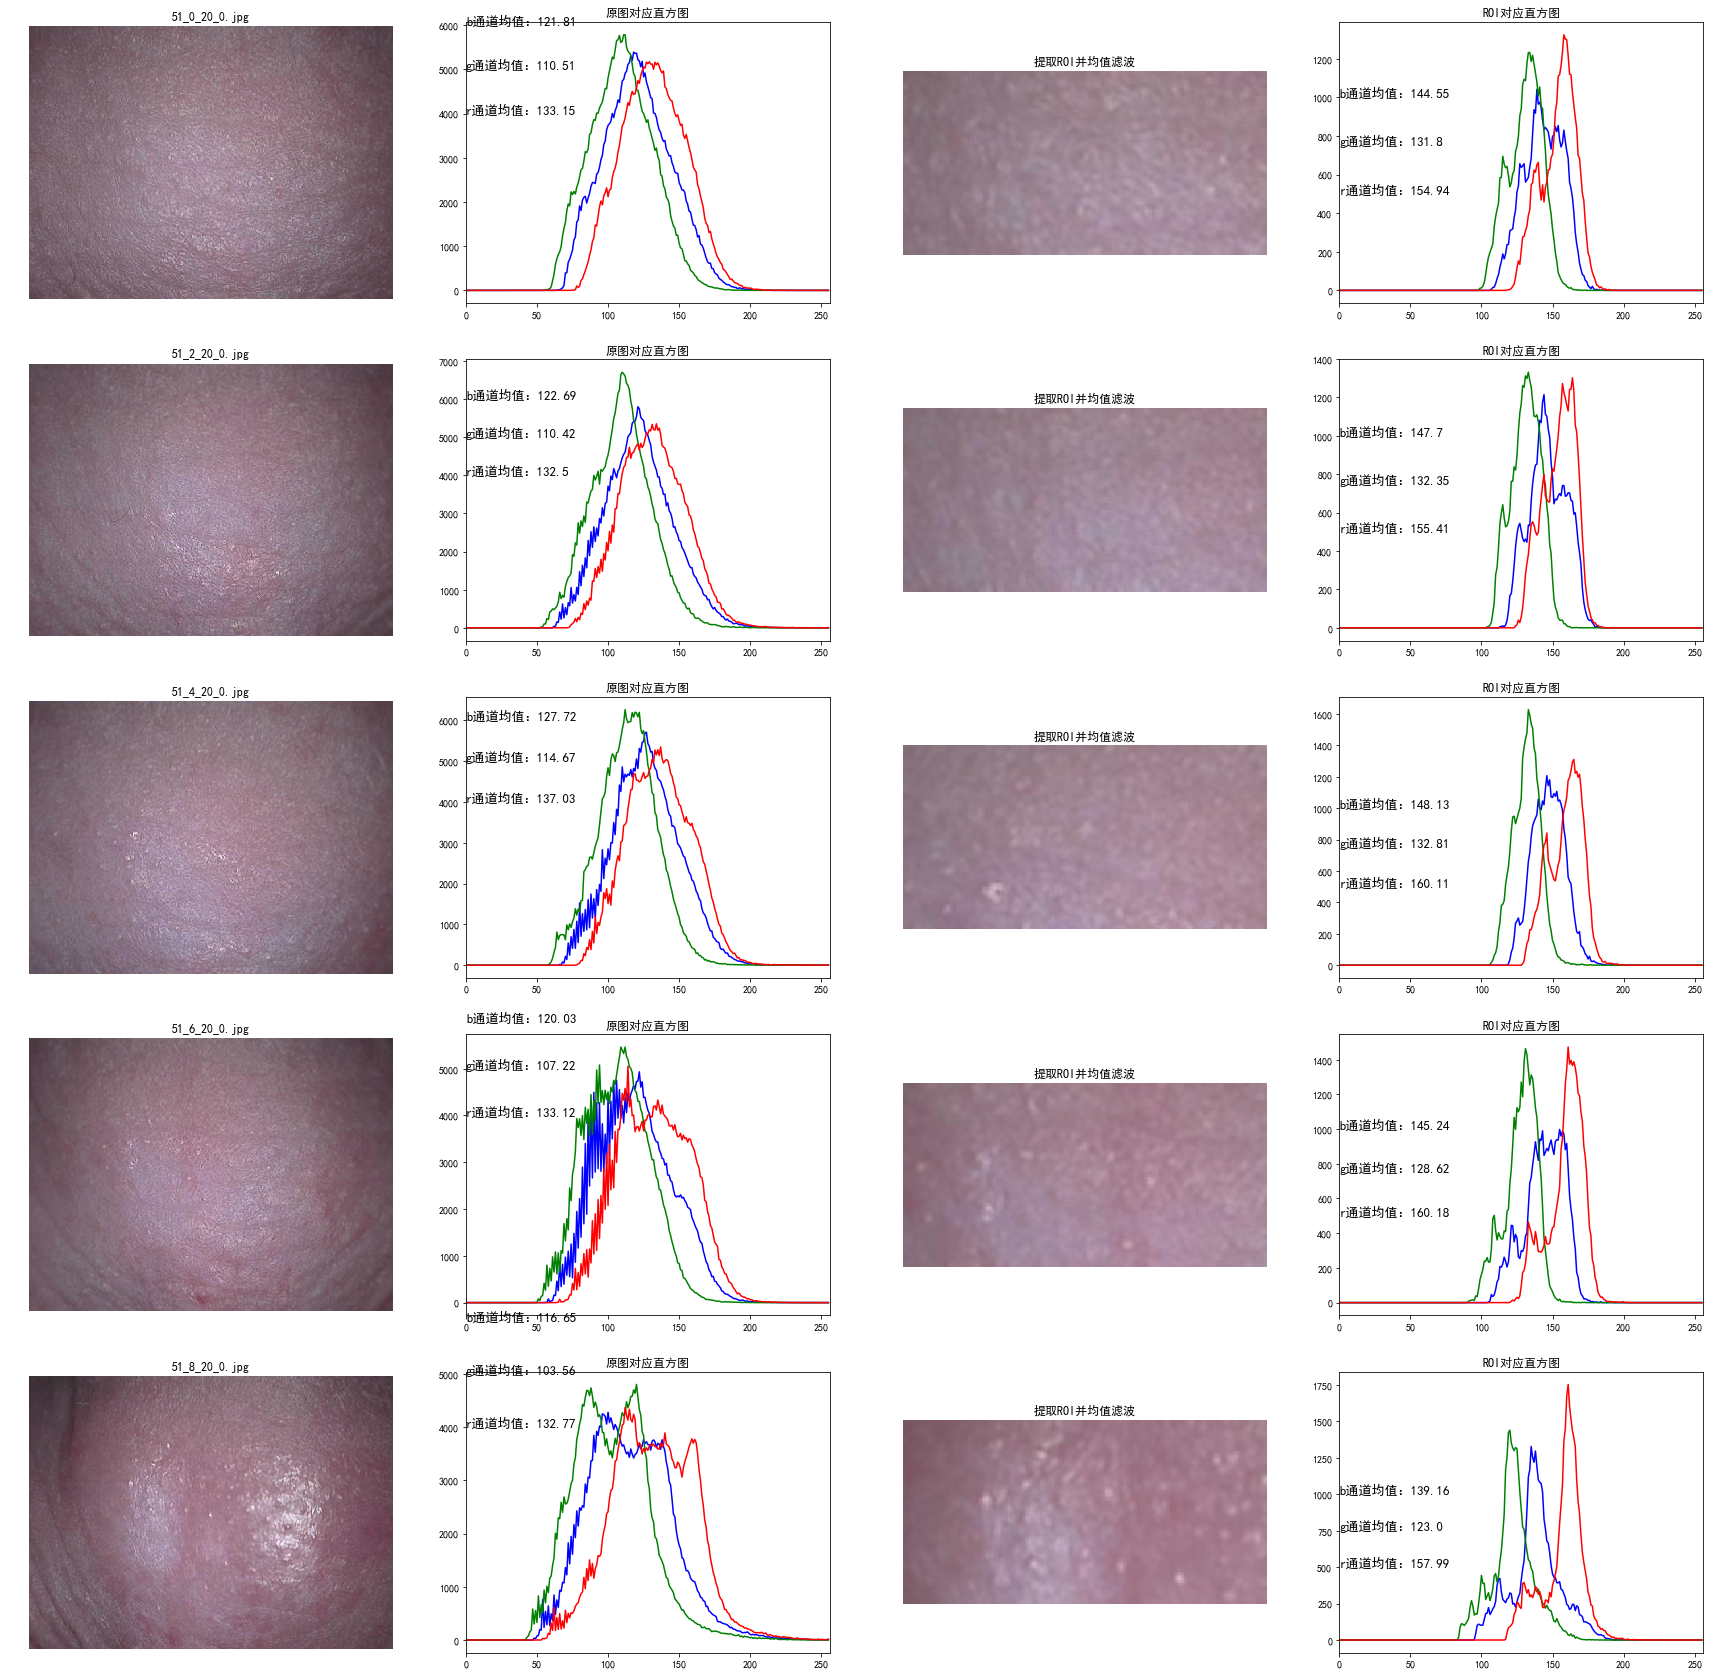

[154.94, 155.41, 160.11000000000001, 160.18000000000001, 157.99000000000001] [131.80000000000001, 132.34999999999999, 132.81, 128.62, 123.0] [144.55000000000001, 147.69999999999999, 148.13, 145.24000000000001, 139.16]


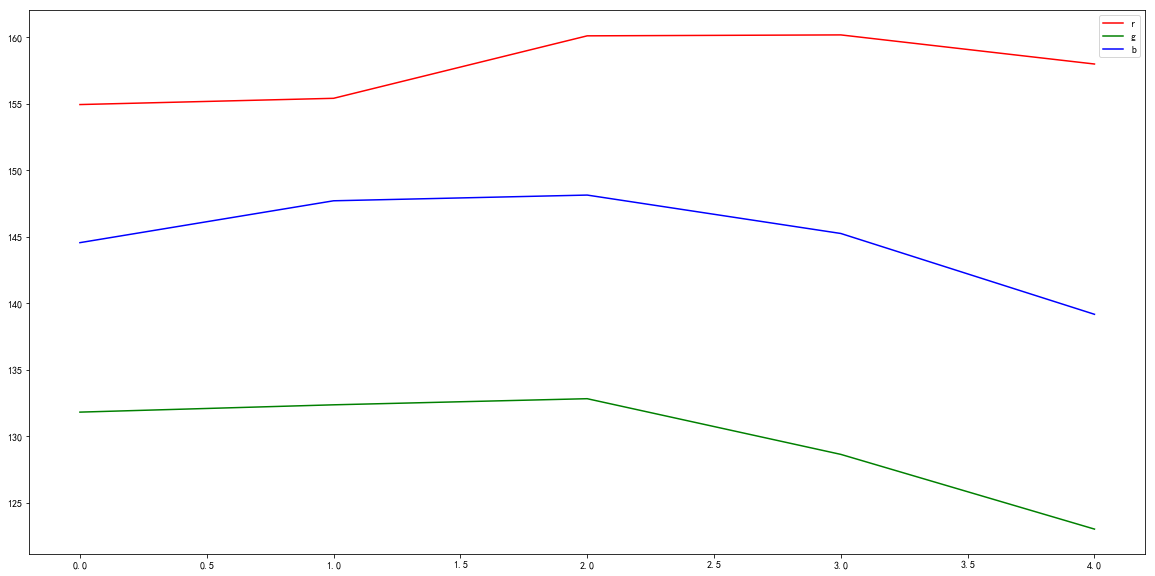

In [82]:

file_path = '../My_image/group_tape_stripping_numbers/51_20_0'
file_list = utils.get_file_list(file_path)
figure = plt.figure(figsize=(30,30))   # 创建画布
gs = gridspec.GridSpec(5,4)          # 创建子图
mean_list = []
i = 0
for file in file_list:
    img = cv2.imread(file_path+'/'+file)
    rgb = img[:,:,::-1]    # BGR转RGB
    plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
    
    ax1 = figure.add_subplot(gs[i,0],title = file)
    ax1.axis('off')
    ax1.imshow(rgb)

    ax2 = figure.add_subplot(gs[i,1],title = '原图对应直方图')
    hist(img,ax2)
    mean = hist_mean(img)
    # mean_list.append(mean)
    # print(mean)
    ax2.text(0, 6000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax2.text(0, 5000, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax2.text(0, 4000, 'r通道均值：'+str(mean[2]), fontsize=13)

    ax3 = figure.add_subplot(gs[i,2],title = '提取ROI并均值滤波')  
    imgROI = img[y:y+h, x:x+w].copy()
    junzhi_result = cv2.blur(imgROI, (5, 5))
    # grayROI = cv2.cvtColor(cv2.blur(imgROI, (5, 5)), cv2.COLOR_BGR2GRAY)
    ax3.axis('off')
    ax3.imshow(junzhi_result[:,:,::-1])

    ax4 = figure.add_subplot(gs[i,3],title = 'ROI对应直方图')
    hist(junzhi_result,ax4)
    mean = hist_mean(junzhi_result)
    mean_list.append(mean)
    # print(mean)
    ax4.text(0, 1000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax4.text(0, 750, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax4.text(0, 500, 'r通道均值：'+str(mean[2]), fontsize=13)
    i += 1
# plot保存图片

plt.savefig('./Result_image/'+re.split('/', file_path)[-1]+str(get_time())+'junzhilvbo.jpg')
plt.show()

colors = ('blue','green','red')
r = []
g = []
b = []
for i,means in enumerate(mean_list):
    r.append(means[2])
    g.append(means[1])
    b.append(means[0])

print(r,g,b)
plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.figure(figsize=(20,10))
plt.plot(r, color='red', label='r')
plt.plot(g, color='green', label='g')
plt.plot(b, color='blue', label='b')
plt.legend()
plt.show()


cv2.waitKey(0)
cv2.destroyAllWindows()

计算五张图片的提取ROI方框滤波直方图(合并在一张图上)

In [ ]:
file_path = '../My_image/group_tape_stripping_numbers/51_20_0'
file_list = utils.get_file_list(file_path)
figure = plt.figure(figsize=(30,30))   # 创建画布
gs = gridspec.GridSpec(5,4)          # 创建子图
mean_list = []
i = 0
for file in file_list:
    img = cv2.imread(file_path+'/'+file)
    rgb = img[:,:,::-1]    # BGR转RGB
    plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
    
    ax1 = figure.add_subplot(gs[i,0],title = file)
    ax1.axis('off')
    ax1.imshow(rgb)

    ax2 = figure.add_subplot(gs[i,1],title = '原图对应直方图')
    hist(img,ax2)
    mean = hist_mean(img)
    # mean_list.append(mean)
    # print(mean)
    ax2.text(0, 3000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax2.text(0, 2000, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax2.text(0, 1000, 'r通道均值：'+str(mean[2]), fontsize=13)

    ax3 = figure.add_subplot(gs[i,2],title = '提取ROI并方框滤波')  
    imgROI = img[y:y+h, x:x+w].copy()
    fangkuang_result = cv2.boxFilter(imgROI, -1, (3, 3), normalize=True)
    # grayROI = cv2.cvtColor(cv2.blur(imgROI, (5, 5)), cv2.COLOR_BGR2GRAY)
    ax3.axis('off')
    ax3.imshow(fangkuang_result[:,:,::-1])

    ax4 = figure.add_subplot(gs[i,3],title = 'ROI对应直方图')
    hist(fangkuang_result,ax4)
    mean = hist_mean(fangkuang_result)
    mean_list.append(mean)
    # print(mean)
    ax4.text(0, 1000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax4.text(0, 750, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax4.text(0, 500, 'r通道均值：'+str(mean[2]), fontsize=13)
    i += 1
# plot保存图片

plt.savefig('./Result_image/'+re.split('/', file_path)[-1]+str(get_time())+'fangkuanglvbo.jpg')
plt.show()

colors = ('blue','green','red')
r = []
g = []
b = []
for i,means in enumerate(mean_list):
    r.append(means[2])
    g.append(means[1])
    b.append(means[0])

print(r,g,b)
plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.figure(figsize=(20,10))
plt.plot(r, color='red', label='r')
plt.plot(g, color='green', label='g')
plt.plot(b, color='blue', label='b')
plt.legend()
plt.show()


cv2.waitKey(0)
cv2.destroyAllWindows()

计算五张图片的提取ROI高斯滤波直方图(合并在一张图上)

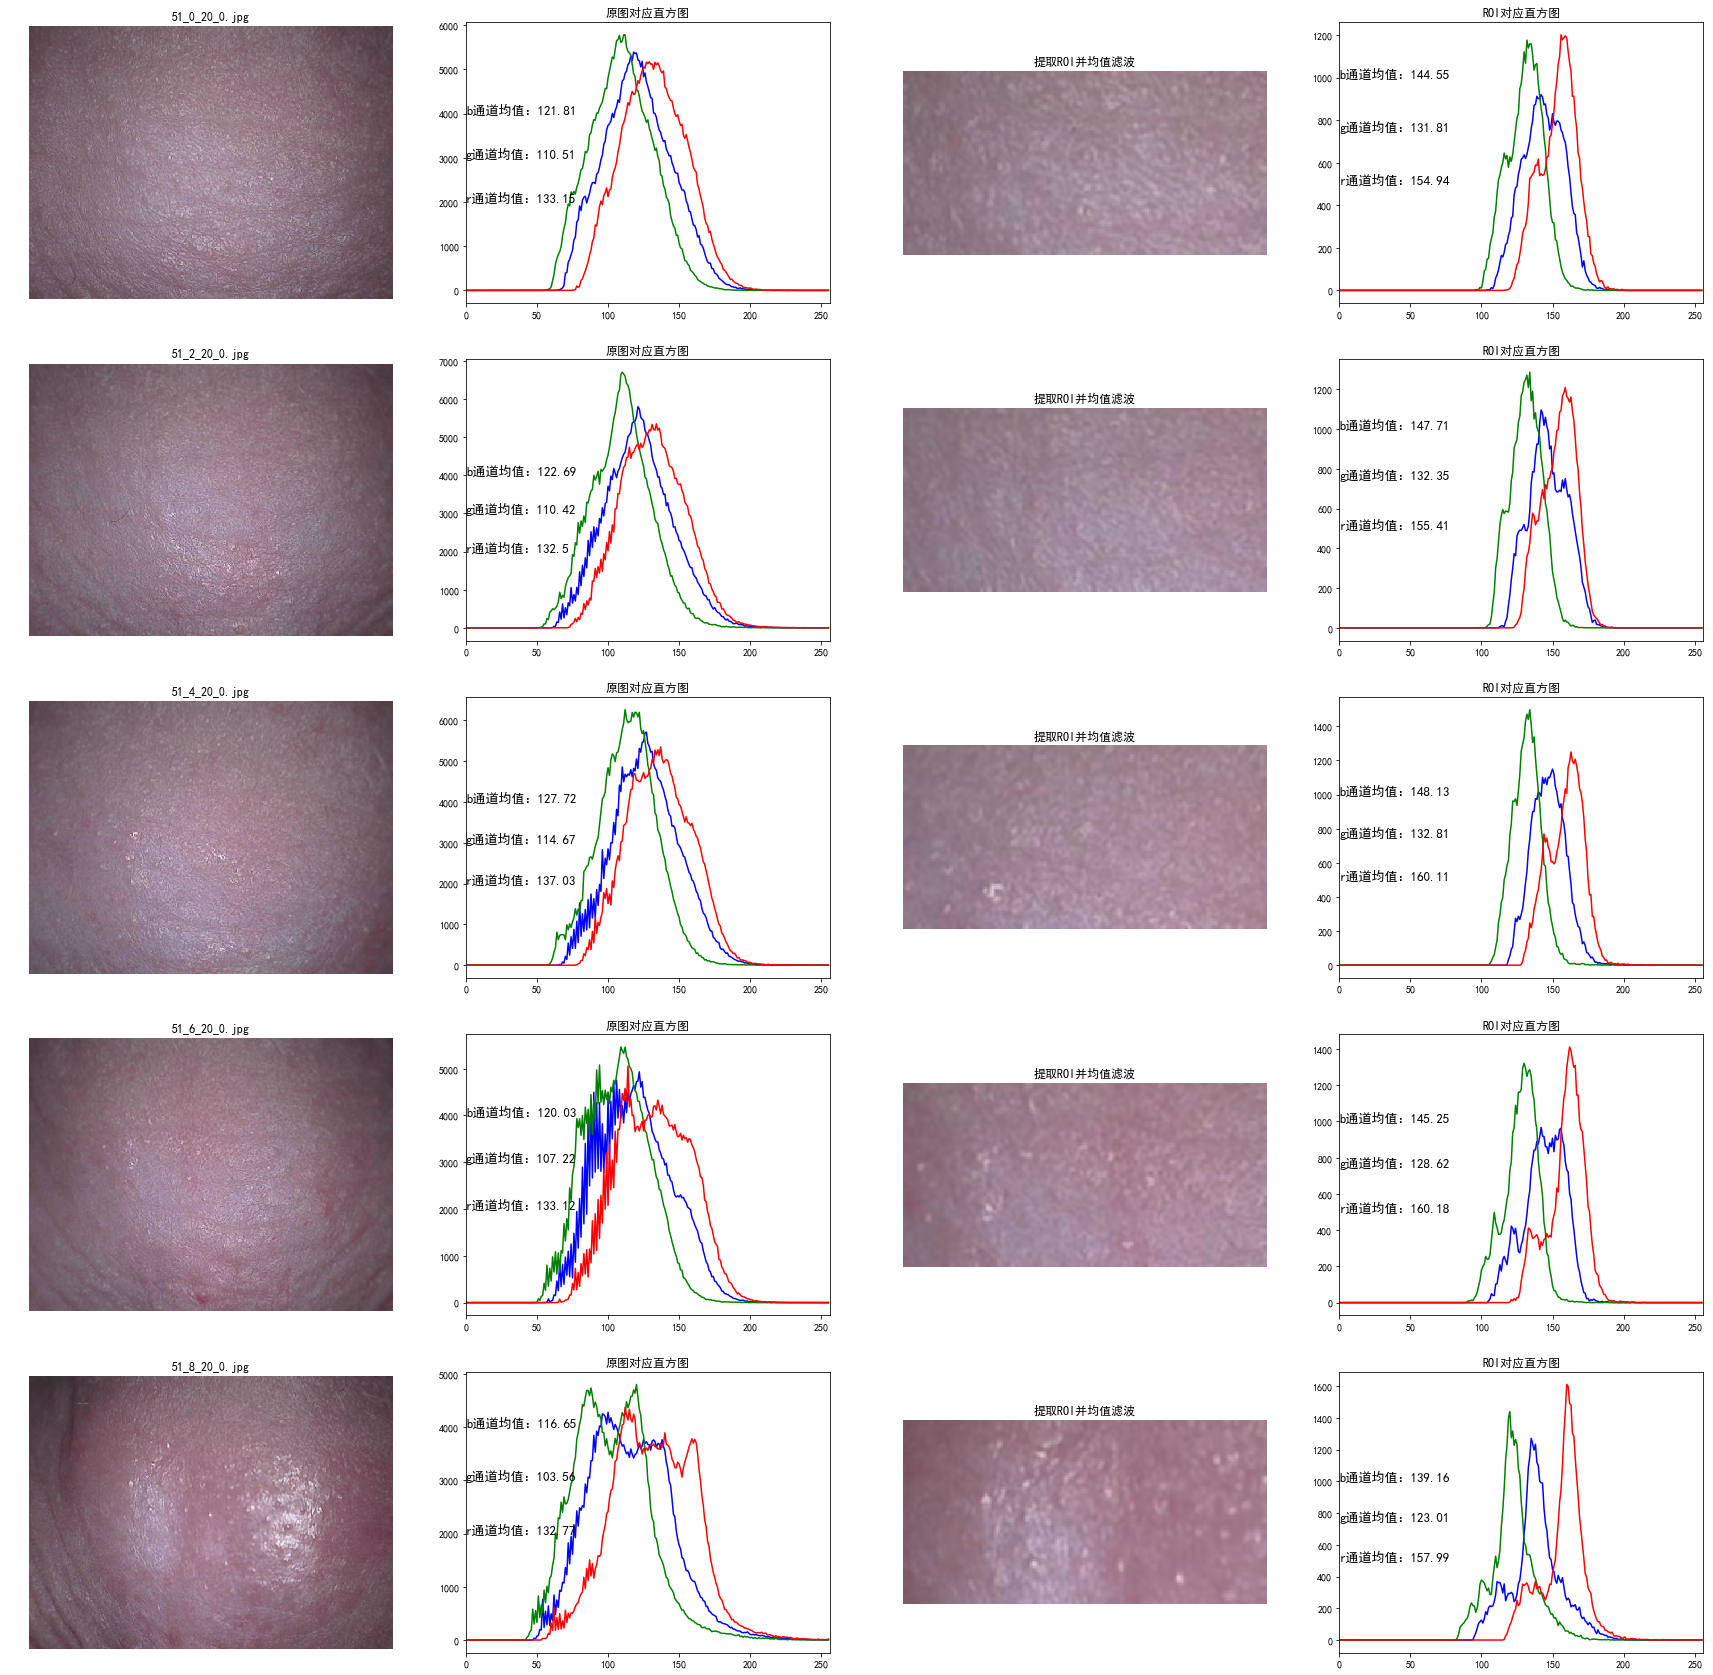

[154.94, 155.41, 160.11000000000001, 160.18000000000001, 157.99000000000001] [131.81, 132.34999999999999, 132.81, 128.62, 123.01000000000001] [144.55000000000001, 147.71000000000001, 148.13, 145.25, 139.16]


TypeError: __init__() got an unexpected keyword argument 'title'

In [10]:

file_path = '../My_image/group_tape_stripping_numbers/51_20_0'
file_list = utils.get_file_list(file_path)
figure = plt.figure(figsize=(30,30))   # 创建画布
gs = gridspec.GridSpec(5,4)          # 创建子图
mean_list = []
i = 0
for file in file_list:
    img = cv2.imread(file_path+'/'+file)
    rgb = img[:,:,::-1]    # BGR转RGB
    plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
    
    ax1 = figure.add_subplot(gs[i,0],title = file)
    ax1.axis('off')
    ax1.imshow(rgb)

    ax2 = figure.add_subplot(gs[i,1],title = '原图对应直方图')
    hist(img,ax2)
    mean = hist_mean(img)
    # mean_list.append(mean)
    # print(mean)
    ax2.text(0, 4000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax2.text(0, 3000, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax2.text(0, 2000, 'r通道均值：'+str(mean[2]), fontsize=13)

    ax3 = figure.add_subplot(gs[i,2],title = '提取ROI并均值滤波')  
    imgROI = img[y:y+h, x:x+w].copy()
    Gauss_result = cv2.GaussianBlur(imgROI, (5, 5), 0)
    # grayROI = cv2.cvtColor(cv2.blur(imgROI, (5, 5)), cv2.COLOR_BGR2GRAY)
    ax3.axis('off')
    ax3.imshow(Gauss_result[:,:,::-1])

    ax4 = figure.add_subplot(gs[i,3],title = 'ROI对应直方图')
    hist(Gauss_result,ax4)
    mean = hist_mean(Gauss_result)
    mean_list.append(mean)
    # print(mean)
    ax4.text(0, 1000, 'b通道均值：'+str(mean[0]), fontsize=13)
    ax4.text(0, 750, 'g通道均值：'+str(mean[1]), fontsize=13)
    ax4.text(0, 500, 'r通道均值：'+str(mean[2]), fontsize=13)
    i += 1
# plot保存图片

# plt.savefig('./Result_image/'+re.split('/', file_path)[-1]+str(get_time())+'Gausslvbo.jpg')
plt.show()

colors = ('blue','green','red')
r = []
g = []
b = []
for i,means in enumerate(mean_list):
    r.append(means[2])
    g.append(means[1])
    b.append(means[0])

print(r,g,b)
plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.figure(figsize=(20,10))
# 

plt.plot(r, color='red', label='r')
plt.plot(g, color='green', label='g')
plt.plot(b, color='blue', label='b')
plt.legend()
plt.show()


cv2.waitKey(0)
cv2.destroyAllWindows()

计算五张图片的直方图(分图展示)

In [74]:
file_list = utils.get_file_list('../My_image/group_tape_stripping_numbers/3_20_0')
i = 0
for file in file_list:
    img = cv2.imread('../My_image/group_tape_stripping_numbers/3_20_0/'+file)
    rgb = img[:,:,::-1]    # BGR转RGB
    plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
    gs = gridspec.GridSpec(1,4)
    plt.subplot(gs[0,i],title = file)
    plt.axis('off')
    plt.imshow(rgb)

    plt.subplot(gs[i,1],title = '原图对应直方图')
    hist(img,ax2)
    mean = hist_mean(img)
    # print(mean)
    plt.text(0, 6000, '直方图b通道均值：'+str(mean[0]), fontsize=13)
    plt.text(0, 5000, '直方图g通道均值：'+str(mean[1]), fontsize=13)
    plt.text(0, 4000, '直方图r通道均值：'+str(mean[2]), fontsize=13)

    ax3 = figure.add_subplot(gs[i,2],title = '提取ROI并均值滤波')  
    imgROI = img[y:y+h, x:x+w].copy()
    junzhi_result = cv2.blur(imgROI, (5, 5))
    # grayROI = cv2.cvtColor(cv2.blur(imgROI, (5, 5)), cv2.COLOR_BGR2GRAY)
    ax3.axis('off')
    ax3.imshow(junzhi_result[:,:,::-1])

    ax4 = figure.add_subplot(gs[i,3],title = 'ROI对应直方图')
    hist(junzhi_result,ax4)
    mean = hist_mean(junzhi_result)
    # print(mean)
    ax4.text(0, 1000, '直方图b通道均值：'+str(mean[0]), fontsize=8)
    ax4.text(0, 750, '直方图g通道均值：'+str(mean[1]), fontsize=8)
    ax4.text(0, 500, '直方图r通道均值：'+str(mean[2]), fontsize=8)
    plt.show()
    i += 1
# plot保存图片
# plt.savefig('./Result_image/3_20_0.jpg')


# src = cv2.imread(r"../My_image/group_tape_stripping_numbers/4_20_0/4_0_20_0.jpg")
# cv2.imshow("image",src)
# cv2.namedWindow("image",cv2.WINDOW_AUTOSIZE)

cv2.waitKey(0)
cv2.destroyAllWindows()

ValueError: Image size of 273x1304680 pixels is too large. It must be less than 2^16 in each direction.

IndexError: index out of range

测试用例

In [59]:
file = '../My_image/group_tape_stripping_numbers/3_20_0'
t = re.split('/', file)
print(t)


['..', 'My_image', 'group_tape_stripping_numbers', '3_20_0']
